In [3]:
import gc  # Python의 가비지 컬렉터 관련 모듈로, 메모리 관리를 위해 객체 삭제를 명시적으로 제어할 수 있습니다.
import itertools  # 반복 가능한 객체로부터 조합, 순열 등 다양한 반복자를 생성하는 유틸리티 모듈입니다.
import matplotlib.pyplot as plt  # 정적/애니메이션/인터랙티브 시각화를 지원하는 matplotlib의 핵심 시각화 도구입니다.
import numpy as np  # 다차원 배열과 행렬 연산, 다양한 수학 함수 제공을 위한 수치 계산 라이브러리입니다.
import pandas as pd  # 데이터 프레임과 시리즈 객체를 기반으로 한 데이터 분석용 라이브러리입니다.
import seaborn as sns  # matplotlib을 기반으로 한 고급 통계 시각화 라이브러리입니다.
import os  # 운영체제와 상호작용하기 위한 모듈로, 파일 경로 탐색 등 OS 의존 기능을 지원합니다.
import xgboost  # 머신러닝용 XGBoost 라이브러리 (주로 회귀, 분류, 랭킹에 사용).
import warnings  # 경고 메시지 필터링 및 제어를 위한 모듈입니다.
import lightgbm as lgbm  # LightGBM: 그래디언트 부스팅 기반 머신러닝 프레임워크입니다.
import lightgbm as lgb  # LightGBM을 다른 별칭으로 중복 임포트 (보통은 하나만 임포트해도 충분합니다).
import ctypes  # C 언어 호환 데이터 타입을 사용하거나 외부 DLL/공유 라이브러리 호출 시 사용되는 모듈입니다.
from sklearn.linear_model import LinearRegression  # 선형 회귀 모델을 구현하는 클래스입니다.

warnings.filterwarnings("ignore")  # 경고 메시지를 무시하여 출력 결과가 지저분하지 않도록 설정합니다.

In [4]:
df_train = pd.read_csv(r"C:\Users\shoot\OneDrive\Desktop\competitive-data-science-predict-future-sales\sales_train.csv")
df_categories = pd.read_csv(r"C:\Users\shoot\OneDrive\Desktop\item_categories.csv")
df_items = pd.read_csv(r"C:\Users\shoot\OneDrive\Desktop\items-translated.csv",  encoding='cp1252')

In [5]:
df_shops = pd.read_csv(r"C:\Users\shoot\OneDrive\Desktop\shops_graded_v2.csv",encoding='ISO-8859-1')
df_test = pd.read_csv(r"C:\Users\shoot\OneDrive\Desktop\competitive-data-science-predict-future-sales\test.csv")
calendar = pd.read_csv(r"C:\Users\shoot\OneDrive\Desktop\calendar.csv")

In [6]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y') 
calendar['date'] = pd.to_datetime(calendar['date'])

df_train = pd.merge(df_train, df_items, on='item_id', how='inner')
df_train = pd.merge(df_train, df_categories, on='item_category_id', how='inner')
df_train = pd.merge(df_train, df_shops, on='shop_id', how='inner')
df_test = pd.merge(df_test, df_items, on='item_id', how='inner')
df_test = pd.merge(df_test, df_categories, on='item_category_id', how='inner')
df_test = pd.merge(df_test, df_shops, on='shop_id', how='inner')
df_train = pd.merge(df_train, calendar, on='date', how='left')

In [7]:
# category, shop 중분류 추가 (12초 소요)
df_train['city'] = df_train['shop_name'].str.split(' ').str[0]
df_train['sub_category'] = df_train['item_category_name'].str.split(' ').str[0]
# 중분류명 정리 → 13개
df_train['sub_category'] = df_train['sub_category'].replace({'Pure' : 'Carrier', 'Clean' : 'Carrier', 'Elements': 'Batteries', 'Payment' : 'Gift Card', 'Service' : 'Tickets', 'Android' : 'Games', 'Mac' : 'Games', 'Game' : 'Games'})
# city명 정리
df_train['city'] = df_train['city'].replace({'!' : 'Yakutsk', 'Exit' : 'Other', 'N.' : 'NizhnyNovgorod', 'SPb' : 'SanktPetersburg', 'Digital' : 'Online'})
# 원화 추가
df_train['total_amount'] = df_train['item_price'] * df_train['item_cnt_day'] # 판매 금액
df_train['krw_amount'] = df_train['total_amount'] * 18 # 국내 보고용 원화 표시, krw_amount로 표시
df_train = df_train.rename({'total_amount':'rub_amount'}, axis = 1)  # 기존 판매금액은 rub_amount로 표시

In [8]:
# date 관련 컬럼 추가 # 보고용이므로 예측에는 불필요 시 사용하지 않아도 됩니다. (7초 소요)
# df_train['date'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y') (merge 직전에 완료)
df_train['year'] =  pd.to_datetime(df_train['date']).apply(lambda x : x.year)
df_train['month'] = pd.to_datetime(df_train['date']).apply(lambda x : x.month)
df_train['day'] = pd.to_datetime(df_train['date']).apply(lambda x : x.day)
df_train['year_month'] = df_train['date'].dt.to_period('M')

In [9]:
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
0,2013-01-02,0,59,22154,999.00,1.0,SCENE 2012 (BD),37,Cinema - Blu -Ray,"Yaroslavl shopping center ""Altair""",...,1,0,Yaroslavl,Cinema,999.00,17982.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,1,0,Moscow,Music,899.00,16182.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,DEEP PURPLE The House Of Blue Light LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,0,1,Moscow,Music,-899.00,-16182.0,2013,1,5,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,DEEP PURPLE Who Do You Think We Are LP,58,Music - vinyl,"Moscow TRK ""Atrium""",...,0,1,Moscow,Music,1709.05,30762.9,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,DEEP PURPLE 30 Very Best Of 2CD (Ð¤Ð¸?Ð¼.),56,Music - CD of corporate production,"Moscow TRK ""Atrium""",...,0,0,Moscow,Music,1099.00,19782.0,2013,1,15,2013-01


In [10]:
df_train[df_train.duplicated() == True]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,holiday,weekend,city,sub_category,rub_amount,krw_amount,year,month,day,year_month
76962,2013-01-05,0,54,20130,149.0,1.0,SCIENTIFIC CHARODEA (region),40,Cinema - DVD,"Khimki shopping center ""mega""",...,0,1,Khimki,Cinema,149.0,2682.0,2013,1,5,2013-01
1435367,2014-02-23,13,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Tyumen TEC ""Goodwin""",...,1,1,Tyumen,Games,999.0,17982.0,2014,2,23,2014-02
1496766,2014-03-23,14,21,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Moscow MTRC ""Afers Mall""",...,0,1,Moscow,Games,999.0,17982.0,2014,3,23,2014-03
1671873,2014-05-01,16,50,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Tyumen TEC ""Goodwin""",...,1,0,Tyumen,Games,999.0,17982.0,2014,5,1,2014-05
1866340,2014-07-12,18,25,3423,999.0,1.0,"Far Cry 3 (Classics) [Xbox 360, Russian version]",23,Games - Xbox 360,"Moscow TRK ""Atrium""",...,0,1,Moscow,Games,999.0,17982.0,2014,7,12,2014-07
2198566,2014-12-31,23,42,21619,499.0,1.0,THE MAN OF RAIN (BD),37,Cinema - Blu -Ray,"SPb TK ""Nevsky Center""",...,0,0,SanktPetersburg,Cinema,499.0,8982.0,2014,12,31,2014-12


In [11]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_train['city_code'] = le.fit_transform(df_train['city'])

In [12]:
df_train.shape

(2935849, 22)

In [13]:
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'item_name_translated', 'item_category_id',
       'item_category_name', 'shop_name', 'shop_grade', 'holiday', 'weekend',
       'city', 'sub_category', 'rub_amount', 'krw_amount', 'year', 'month',
       'day', 'year_month', 'city_code'],
      dtype='object')

In [14]:
df_train['item_cnt_month'] = (
    df_train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day']
         .transform('sum')
)

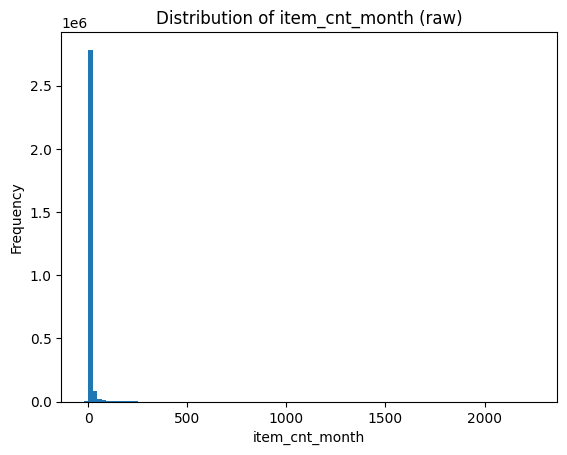

In [15]:
plt.hist(df_train['item_cnt_month'], bins=100)
plt.title("Distribution of item_cnt_month (raw)")
plt.xlabel("item_cnt_month")  # item_cnt_month 값
plt.ylabel("Frequency")  # 해당 판매량을 가진 row 수 (데이터 수) 즉 그 판매량을 가진 shop_id + item_id + date_block_num 조합 수
plt.show()

In [16]:
from scipy.stats import kruskal
import pandas as pd

def auto_stat_test(df, target='item_cnt_month', alpha=0.05):
    results = []

    for col in df.columns:
        if col == target:
            continue
        # 10개 이하 유니크 값 & 범주형 컬럼만 검사
        if df[col].nunique() <= 100 and df[col].dtype in ['int64', 'object', 'category']:
            try:
                groups = [g[target].values for _, g in df.groupby(col)]
                stat, p = kruskal(*groups)
                results.append({'feature': col, 'p_value': p})
            except:
                continue

    result_df = pd.DataFrame(results)
    result_df['significant'] = result_df['p_value'] < alpha
    return result_df.sort_values('p_value')

In [17]:
result = auto_stat_test(df_train)
print(result)

               feature        p_value  significant
0       date_block_num   0.000000e+00         True
1              shop_id   0.000000e+00         True
2     item_category_id   0.000000e+00         True
3   item_category_name   0.000000e+00         True
4            shop_name   0.000000e+00         True
5           shop_grade   0.000000e+00         True
9         sub_category   0.000000e+00         True
8                 city   0.000000e+00         True
13           city_code   0.000000e+00         True
11               month   0.000000e+00         True
10                year   0.000000e+00         True
12                 day  1.288345e-248         True
7              weekend  6.084938e-161         True
6              holiday   1.105208e-36         True


In [18]:
# KMeans 클러스터링 함수 정의
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def new_kmeans_cluster_features(
        df,
        index_col,
        column_col,
        aggfunc,
        new_feature_name,
        n_clusters,
        target='item_cnt_month'
):
    
    X = pd.pivot_table(
        data=df,
        index=index_col,
        columns=column_col,
        aggfunc=aggfunc,
        values=target
    ).fillna(0)

    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    model = KMeans(
        n_clusters=n_clusters,
        random_state=42
    )
    labels = model.fit_predict(X)

    mapping = dict(zip(X.index, labels))
    return df[index_col].map(mapping).rename(new_feature_name)

In [19]:
# KMeans 피처 이름 생성 

def run_KMeans_cluster_features(
        df,
        groups,
        aggfunc,
        n_clusters,
        target='item_cnt_month'
):
    df = df.copy()

    for group1, group2 in groups:
        for agg in aggfunc:
            for n in n_clusters:

                new_feature_name = f'{group1}_{group2}_{agg}_KMeansClustering_{n}'

                if new_feature_name in df.columns:
                    continue

                cluster_feature = new_kmeans_cluster_features(
                    df=df,
                    index_col=group1,
                    column_col=group2,
                    aggfunc=agg,
                    n_clusters=n,
                    target=target,
                    new_feature_name=new_feature_name
                )

                df[new_feature_name] = cluster_feature

    return df

In [20]:
groups = [('item_id', 'date_block_num'),    # 상품별 월간 수요 흐름 → 시즌성 or 꾸준한 인기 품목 분류
 ('shop_id', 'date_block_num'),    # 매장별 월간 수요 흐름 → 매장 특성 군집화
 ('item_category_id', 'date_block_num')]     # 카테고리별 트렌드 군집화 → 전략 대상 분류
aggfunc = ['sum', 'mean']
n_clusters = [3, 4, 5]

df_train = run_KMeans_cluster_features(df_train, groups, aggfunc, n_clusters, target='item_cnt_month')

In [21]:
# 계층군집 클러스터링
from sklearn.cluster import AgglomerativeClustering

def new_AgglomerativeClustering_cluster_features(
        df,
        index_col,
        column_col,
        aggfunc,
        new_feature_name,
        n_clusters, 
        target='item_cnt_month'
):
    
    X = pd.pivot_table(
        data=df,
        index=index_col,
        columns=column_col,
        values=target).fillna(0)  # 안전장치

    model = AgglomerativeClustering(
        n_clusters=n_clusters,
        linkage='ward'
    )
    model.fit(X)
    labels = model.labels_

    mapping = dict(zip(X.index, labels))
    return df[index_col].map(mapping).rename(new_feature_name)

In [22]:
# # 계층클러스터 피처 이름 생성 

def run_AgglomerativeClustering_cluster_features(
        df,
        groups,
        aggfunc,
        n_clusters,
        target='item_cnt_month'
        
):
    df = df.copy()

    for group1, group2 in groups:
        for agg in aggfunc:
            for n in n_clusters:
                
                new_feature_name = f'{group1}_{group2}_{agg}_AgglomerativeClustering_{n}'

                if new_feature_name in df.columns:
                    continue

                cluster_feature = new_AgglomerativeClustering_cluster_features(
                    df=df,
                    index_col=group1,
                    column_col=group2,
                    aggfunc=agg,
                    n_clusters=n,
                    target=target,
                    new_feature_name=new_feature_name
)
                df[new_feature_name] = cluster_feature

    return df

In [23]:
groups = [('item_id', 'date_block_num'),    # 상품별 월간 수요 흐름 → 시즌성 or 꾸준한 인기 품목 분류
 ('shop_id', 'date_block_num'),    # 매장별 월간 수요 흐름 → 매장 특성 군집화
 ('item_category_id', 'date_block_num')]     # 카테고리별 트렌드 군집화 → 전략 대상 분류
aggfunc = ['sum', 'mean']
n_clusters = [3, 4, 5]

df_train = run_AgglomerativeClustering_cluster_features(df_train, groups, aggfunc, n_clusters, target='item_cnt_month')

In [24]:
def aff_rolling_stats(
        df,
        group_cols,
        target='item_cnt_month',
        window_sizes=[1, 3, 6, 12]
):
    for group1, group2 in group_cols:
        df = df.sort_values(by=[group1, group2, 'date_block_num'])
        grouped = df.groupby([group1, group2])[target]

        for window in window_sizes:
            mean_col = f'rolling_mean_{window}_{group1}_{group2}'
            std_col = f'rolling_std_{window}_{group1}_{group2}'
            var_col = f'rolling_var_{window}_{group1}_{group2}'
            cv_col = f'rolling_cv_{window}_{group1}_{group2}'

            df[mean_col] = grouped.transform(lambda x: x.rolling(window, min_periods=1).mean())
            df[std_col] = grouped.transform(lambda x: x.rolling(window, min_periods=1).std())
            df[var_col] = grouped.transform(lambda x: x.rolling(window, min_periods=1).var())
            df[cv_col] = df[std_col] / (df[mean_col] + 1e-9)

    return df

In [25]:
def aff_ewm_stats(
        df,
        group_cols,
        target = 'item_cnt_month',
        span_list=[1, 3, 6, 12]
):
    for group1, group2 in group_cols:
        df = df.sort_values(by=[group1, group2, 'date_block_num'])
        grouped = df.groupby([group1, group2])[target]

        for span in  span_list:
            mean_col = f'span_mean_{span}_{group1}_{group2}'
            std_col = f'span_std_{span}_{group1}_{group2}'
            var_col = f'span_var_{span}_{group1}_{group2}'
            cv_col = f'span_cv_{span}_{group1}_{group2}'

            df[mean_col] = grouped.transform(lambda x: x.ewm(span=span, min_periods=1).mean())
            df[std_col] = grouped.transform(lambda x: x.ewm(span=span, min_periods=1).std())
            df[var_col] = grouped.transform(lambda x: x.ewm(span=span, min_periods=1).var())
            df[cv_col] = df[std_col] / (df[mean_col] + 1e-9)

    return df

In [26]:
group_cols = [('shop_id', 'date_block_num'),  # 매장별 전략 수립이 핵심. 트렌드 분석과 예측에서 "매장 단위"는 기본 분석 단위로 들어가야 함.
              ('item_category_id', 'date_block_num'),  # 카테고리별 판매/운영 SKU/판매량 변화 분석. 카테고리 전략 수립의 핵심이 되는 그룹 기준.
              ('city_code', 'date_block_num')]   # 	지역 기반 전략 수립 가능. 도심과 지방 간 트렌드 차이, 프로모션 효과 지역별 분석에 활용 가능.
window_sizes = [1, 3, 6, 12]
span_list = window_sizes
# 1: 프로모션 직후 반응, 단기 급등락 확인. 할인 여부 영향 분석에 사용.
# 3: 최근 분기 기준 트렌드 확인. 전월 대비, 단기 SKU 반응도 평가에 활용.
# 6: 반년치 누적 트렌드. 시즌성, 중기 추세, 가격/판매 변화 누적 확인용.
# 12: 전년 동월 대비 분석. "전년 동월 대비 상승/하락" 문제 정의에 정확히 부합.

df_train = aff_rolling_stats(df_train, group_cols, 'item_cnt_month', window_sizes)
df_train =aff_ewm_stats(df_train, group_cols,'item_cnt_month', span_list)

In [27]:
# shop_id 기준
df_train = df_train.sort_values(by=['shop_id', 'date_block_num'])

df_train['item_cnt_month_diff_1m'] = df_train.groupby('shop_id')['item_cnt_month'].transform(lambda x: x.diff(1))  # 매장 전체의 전월 대비 월간 판매량 증감
df_train['item_cnt_month_pct_change_1m'] = df_train.groupby('shop_id')['item_cnt_month'].transform(lambda x: x.pct_change(1).fillna(0))  # 매장 전체의 전월 대비 월간 판매량 증감율

df_train['item_cnt_month_diff_12m'] = df_train.groupby('shop_id')['item_cnt_month'].transform(lambda x: x.diff(12))  # 매장 전체의 전년 동월 대비 월간 판매량 차이 
df_train['item_cnt_month_pct_change_12m'] = df_train.groupby('shop_id')['item_cnt_month'].transform(lambda x: x.pct_change(12).fillna(0))  # 매장 전체의 전년 동월 대비 월간 판매량 증감율

In [28]:
# item_category_id 기준 
df_train = df_train.sort_values(by=['item_category_id', 'date_block_num'])

df_train['item_cnt_month_diff_1m'] = df_train.groupby('item_category_id')['item_cnt_month'].transform(lambda x: x.diff(1))  # 카테고리 전체의 전월 대비 월간 판매량 증감 (절대량)
df_train['item_cnt_month_pct_change_1m'] = df_train.groupby('item_category_id')['item_cnt_month'].transform(lambda x: x.pct_change(1).fillna(0))  # 카테고리 전체의 전월 대비 월간 판매량 증감율

df_train['item_cnt_month_diff_12m'] = df_train.groupby('item_category_id')['item_cnt_month'].transform(lambda x: x.diff(12))  # 카테고리 전체의 전년 동월 대비 월간 판매량 차이
df_train['item_cnt_month_pct_change_12m'] = df_train.groupby('item_category_id')['item_cnt_month'].transform(lambda x: x.pct_change(12).fillna(0))  # 카테고리 전체의 전년 동월 대비 월간 판매량 증감율

In [29]:
df_train.fillna(0)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_name_translated,item_category_id,item_category_name,shop_name,...,span_var_6_city_code_date_block_num,span_cv_6_city_code_date_block_num,span_mean_12_city_code_date_block_num,span_std_12_city_code_date_block_num,span_var_12_city_code_date_block_num,span_cv_12_city_code_date_block_num,item_cnt_month_diff_1m,item_cnt_month_pct_change_1m,item_cnt_month_diff_12m,item_cnt_month_pct_change_12m
5558,2013-01-10,0,25,16257,148.0,1.0,Headphones RITMIX RH-124 Black,0,PC - headsets/headphones,"Moscow TRK ""Atrium""",...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
182616,2013-02-28,1,0,16255,93.0,1.0,Headphones PHILIPS SBC HC8680,0,PC - headsets/headphones,"! Yakutsk Ordzhonikidze, 56",...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
439377,2013-04-02,3,38,16256,22.4,1.0,Headphones RITMIX RH-120,0,PC - headsets/headphones,"Omsk shopping center ""Mega""",...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
112968,2013-01-10,0,45,5606,148.0,1.0,PS2: Memory Card 8 MB Black (Memory Card 8Mb -...,1,Accessories - PS2,"Samara shopping center ""Parkhouse""",...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
181531,2013-02-20,1,0,5740,283.0,1.0,Pelican. ?ÐµÐ¹Ð¼Ð¿Ð°Ð´ Nerf Wireless Controlle...,1,Accessories - PS2,"! Yakutsk Ordzhonikidze, 56",...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2899132,2015-10-18,33,59,22087,119.0,3.0,Battery DURACELL LR03-BC2,83,Elements of nutrition,"Yaroslavl shopping center ""Altair""",...,15.033805,0.411181,9.936107,3.963139,15.706468,0.398862,0.0,0.000000,-6.0,-0.500000
2899133,2015-10-23,33,59,22087,119.0,1.0,Battery DURACELL LR03-BC2,83,Elements of nutrition,"Yaroslavl shopping center ""Altair""",...,13.619244,0.436745,9.330552,3.935768,15.490269,0.421815,0.0,0.000000,-6.0,-0.500000
2899134,2015-10-03,33,59,22088,119.0,1.0,Battery DURACELL LR06-BC2,83,Elements of nutrition,"Yaroslavl shopping center ""Altair""",...,19.915877,0.675451,8.202775,4.553948,20.738440,0.555172,-4.0,-0.666667,-10.0,-0.833333
2899135,2015-10-27,33,59,22088,119.0,1.0,Battery DURACELL LR06-BC2,83,Elements of nutrition,"Yaroslavl shopping center ""Altair""",...,19.423507,0.833006,7.248502,4.797055,23.011734,0.661799,0.0,0.000000,-10.0,-0.833333


In [30]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2935849 entries, 5558 to 2899136
Columns: 159 entries, date to item_cnt_month_pct_change_12m
dtypes: datetime64[ns](1), float64(105), int32(18), int64(28), object(6), period[M](1)
memory usage: 3.3+ GB


In [31]:
drop_cols = df_train.select_dtypes(include=['object', 'datetime']).columns.tolist()
df_train = df_train.drop(drop_cols, axis=1)

In [32]:
df_train = df_train.drop('year_month', axis=1)

In [33]:
cluster_features = [col for col in df_train.columns if 'AgglomerativeClustering' in col or 'KMeansClustering' in col]

rolling_ewm_features = [col for col in df_train.columns if (
    'rolling' in col or 'ewm' in col or 'span' in col
)]

diff_pct_features = [col for col in df_train.columns if (
    'diff' in col or 'pct_change' in col
)]

In [36]:
from lightgbm import LGBMRegressor

target = 'item_cnt_month'

X = df_train.drop(columns=[target])
y = df_train[target]

model = LGBMRegressor(random_state=42)
model.fit(X, y)

importances = model.feature_importances_
top_n = 50

top_features = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(top_n)

print(top_features)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.907800 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22231
[LightGBM] [Info] Number of data points in the train set: 2935849, number of used features: 132
[LightGBM] [Info] Start training from score 7.400887
rolling_mean_1_shop_id_date_block_num                      1511
date_block_num                                              219
item_cnt_day                                                160
month                                                       130
rub_amount                                                  113
item_cnt_month_diff_12m                                     102
shop_id                                                      92
rolling_mean_3_item_category_id_date_block_num               58
item_cnt_month_pct_change_12m                                37
day                                                          35
rolling_mean_3

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X = df_train[top_features.index]
y = df_train['item_cnt_month']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
rmse = mean_squared_error(y_val, y_pred) ** 0.5

print(round(rmse, 4))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.161051 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7897
[LightGBM] [Info] Number of data points in the train set: 2348679, number of used features: 50
[LightGBM] [Info] Start training from score 7.400482
0.2804


In [38]:
# 음수 제거 + 로그 변환
df = df_train[df_train['item_cnt_month'] >= 0].copy()
df['item_cnt_month'] = np.log1p(df['item_cnt_month'])

X = df[top_features.index]
y = df['item_cnt_month']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = LGBMRegressor(random_state=42, n_jobs=-1)
model.fit(X_train, y_train)

# 예측 + 복구
y_pred = model.predict(X_val)
rmse = mean_squared_error(np.expm1(y_val), np.expm1(y_pred)) ** 0.5
print(f"RMSE (log1p + LGBM): {round(rmse, 4)}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.551018 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7891
[LightGBM] [Info] Number of data points in the train set: 2347904, number of used features: 50
[LightGBM] [Info] Start training from score 1.442615
RMSE (log1p + LGBM): 0.1546


In [39]:
# 음수 제거 후 로그 변환
df = df_train[df_train['item_cnt_month'] >= 0].copy()
df['item_cnt_month'] = np.log1p(df['item_cnt_month'])

X_all = df.drop(columns=['item_cnt_month'])
y_all = df['item_cnt_month']

# 먼저 데이터 분할 (리크 방지!)
X_train, X_val, y_train, y_val = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42
)

# LGBM으로 피처 중요도 구하기 (train 데이터만 사용) 
model = LGBMRegressor(random_state=42)
model.fit(X_train, y_train)

feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
top_features = feature_importance.sort_values(ascending=False).head(50).index.tolist()

# top 50으로 다시 모델 학습
model_final = LGBMRegressor(random_state=42)
model_final.fit(X_train[top_features], y_train)

# 예측 및 복원
y_pred = model_final.predict(X_val[top_features])
rmse = mean_squared_error(np.expm1(y_val), np.expm1(y_pred)) ** 0.5

print(f"RMSE (no leakage + log1p + top 50): {round(rmse, 4)}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.404832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 22226
[LightGBM] [Info] Number of data points in the train set: 2347904, number of used features: 132
[LightGBM] [Info] Start training from score 1.442615
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7240
[LightGBM] [Info] Number of data points in the train set: 2347904, number of used features: 50
[LightGBM] [Info] Start training from score 1.442615
RMSE (no leakage + log1p + top 50): 0.1649


In [40]:
X_train.nunique()[X_train.nunique() > 20000].index.tolist()

['item_id',
 'rub_amount',
 'krw_amount',
 'rolling_std_3_shop_id_date_block_num',
 'rolling_var_3_shop_id_date_block_num',
 'rolling_cv_3_shop_id_date_block_num',
 'rolling_std_6_shop_id_date_block_num',
 'rolling_var_6_shop_id_date_block_num',
 'rolling_cv_6_shop_id_date_block_num',
 'rolling_std_12_shop_id_date_block_num',
 'rolling_var_12_shop_id_date_block_num',
 'rolling_cv_12_shop_id_date_block_num',
 'rolling_std_3_item_category_id_date_block_num',
 'rolling_var_3_item_category_id_date_block_num',
 'rolling_cv_3_item_category_id_date_block_num',
 'rolling_std_6_item_category_id_date_block_num',
 'rolling_var_6_item_category_id_date_block_num',
 'rolling_cv_6_item_category_id_date_block_num',
 'rolling_std_12_item_category_id_date_block_num',
 'rolling_var_12_item_category_id_date_block_num',
 'rolling_cv_12_item_category_id_date_block_num',
 'rolling_std_3_city_code_date_block_num',
 'rolling_var_3_city_code_date_block_num',
 'rolling_cv_3_city_code_date_block_num',
 'rolling_s

In [41]:
print("y_val max:", np.expm1(y_val).max())

y_val max: 2253.000000000001


In [42]:
def full_forecasting_pipeline_with_val_outlier_removal(df_train, clip_threshold=100):
    # Step 1: 이상치 제거 (train만)
    df = df_train[(df_train['item_cnt_month'] >= 0) & (df_train['item_cnt_month'] <= clip_threshold)].copy()

    # Step 2: 로그 변환
    df['item_cnt_month'] = np.log1p(df['item_cnt_month'])

    # Step 3: X, y 분리
    X_all = df.drop(columns=['item_cnt_month'])
    y_all = df['item_cnt_month']

    # Step 4: 시계열 누수 방지 분할
    X_train = X_all[df['date_block_num'] < 33]
    y_train = y_all[df['date_block_num'] < 33]
    X_val = X_all[df['date_block_num'] == 33]
    y_val = y_all[df['date_block_num'] == 33]

    # Step 5: 피처 중요도 기반 Top 50 추출
    model = LGBMRegressor(random_state=42)
    model.fit(X_train, y_train)
    feature_importance = pd.Series(model.feature_importances_, index=X_train.columns)
    top_features = feature_importance.sort_values(ascending=False).head(50).index.tolist()

    # Step 6: Top 50 피처로 재학습
    model_final = LGBMRegressor(random_state=42)
    model_final.fit(X_train[top_features], y_train)

    # Step 7: 예측 + 복원
    y_pred_log = model_final.predict(X_val[top_features])
    y_pred = np.expm1(y_pred_log)
    y_val_real = np.expm1(y_val)

    # Step 8: 전체 RMSE
    full_rmse = mean_squared_error(y_val_real, y_pred) ** 0.5

    # Step 9: val 이상치 제거 후 RMSE
    mask = y_val_real <= clip_threshold
    y_val_clean = y_val_real[mask]
    y_pred_clean = y_pred[mask]
    adjusted_rmse = mean_squared_error(y_val_clean, y_pred_clean) ** 0.5

    return {
        'standard_rmse': full_rmse,
        'adjusted_rmse': adjusted_rmse,
        'val_sample_count': len(y_val_clean),
        'top_features': top_features,
        'model': model_final
    }

In [43]:
result = full_forecasting_pipeline_with_val_outlier_removal(df_train)

print("Standard RMSE:", result['standard_rmse'])
print("Adjusted RMSE (val 이상치 제거):", result['adjusted_rmse'])
print("Val 샘플 수:", result['val_sample_count'])

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.366783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21086
[LightGBM] [Info] Number of data points in the train set: 2858077, number of used features: 132
[LightGBM] [Info] Start training from score 1.413147
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.221207 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1547
[LightGBM] [Info] Number of data points in the train set: 2858077, number of used features: 50
[LightGBM] [Info] Start training from score 1.413147
Standard RMSE: 0.000981971299115789
Adjusted RMSE (val 이상치 제거): 0.000981971299115789
Val 샘플 수: 53179


In [44]:
df_train['item_cnt_month'].nunique()

446

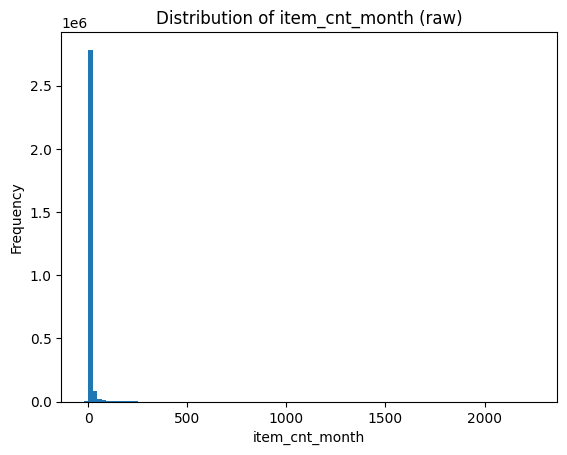

In [45]:
plt.hist(df_train['item_cnt_month'], bins=100)
plt.title("Distribution of item_cnt_month (raw)")
plt.xlabel("item_cnt_month")  # item_cnt_month 값
plt.ylabel("Frequency")  # 해당 판매량을 가진 row 수 즉 그 판매량을 가진 shop_id + item_id + date_block_num 조합 수
plt.show()

### 전체 데이터는 판매량이 0인 사례가 대다수로, 월간 판매량 분포가 극도로 불균형합니다
### 예측해야 할 값 자체가 대부분 0 근처라서, 모델이 그냥 0만 예측해도 꽤 괜찮게 맞아버리는 착시 현상도 생길 수 있다.

### 이번 문제의 타겟 변수인 item_cnt_month는 대부분 값이 0~2에 집중되어 있고, 일부는 1000 이상인 아웃라이어가 존재하는 극단적 long-tail 분포를 보입니다. 이로 인해 일반적인 RMSE 계산에서 소수의 큰 오차가 전체 점수를 왜곡시키는 문제가 있었고, 이를 보완하기 위해 로그 변환 및 이상치 제거를 적용했습니다. 그 결과, RMSE가 0.1대에서 11대로 올라간 것은 모델이 망가진 것이 아니라, 실제 판매량 기준의 정상적인 오차 수치로 환산된 결과입니다. 현실적인 모델 평가를 위해선 이 방식이 더 합리적이라 판단했습니다.

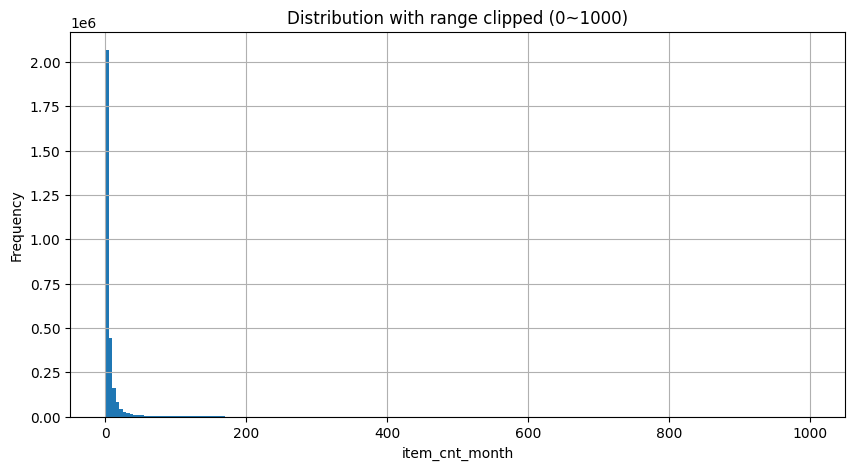

In [46]:
plt.figure(figsize=(10, 5))
plt.hist(df_train['item_cnt_month'], bins=200, range=(0, 1000))
plt.title("Distribution with range clipped (0~1000)")
plt.xlabel("item_cnt_month")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# 종속 변수
target_col = 'item_cnt_month'

# 상관관계 시각화 함수
def plot_correlation_heatmap(df, feature_group, group_name):
    features = [target_col] + feature_group
    corr = df[features].corr()

    plt.figure(figsize=(10, len(features) * 0.4 + 2))
    sns.heatmap(corr[[target_col]].sort_values(by=target_col, ascending=False), annot=True, cmap='coolwarm', center=0)
    plt.title(f"Correlation of {group_name} Features with '{target_col}'")
    plt.show()


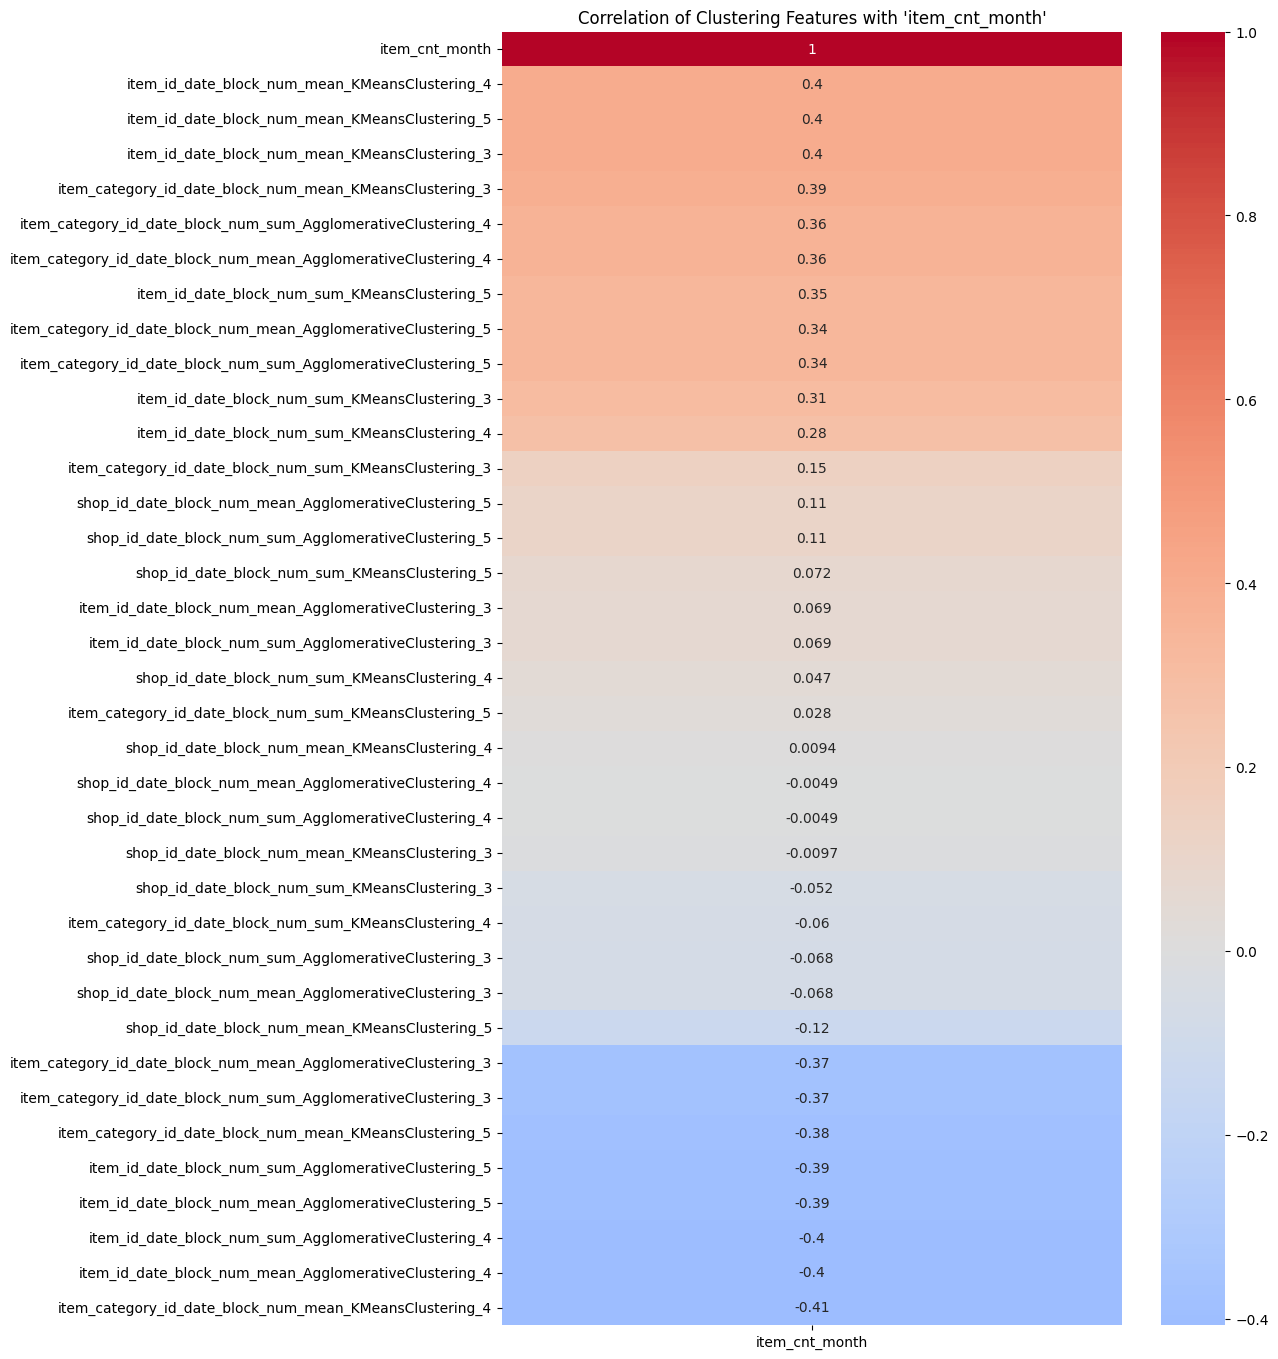

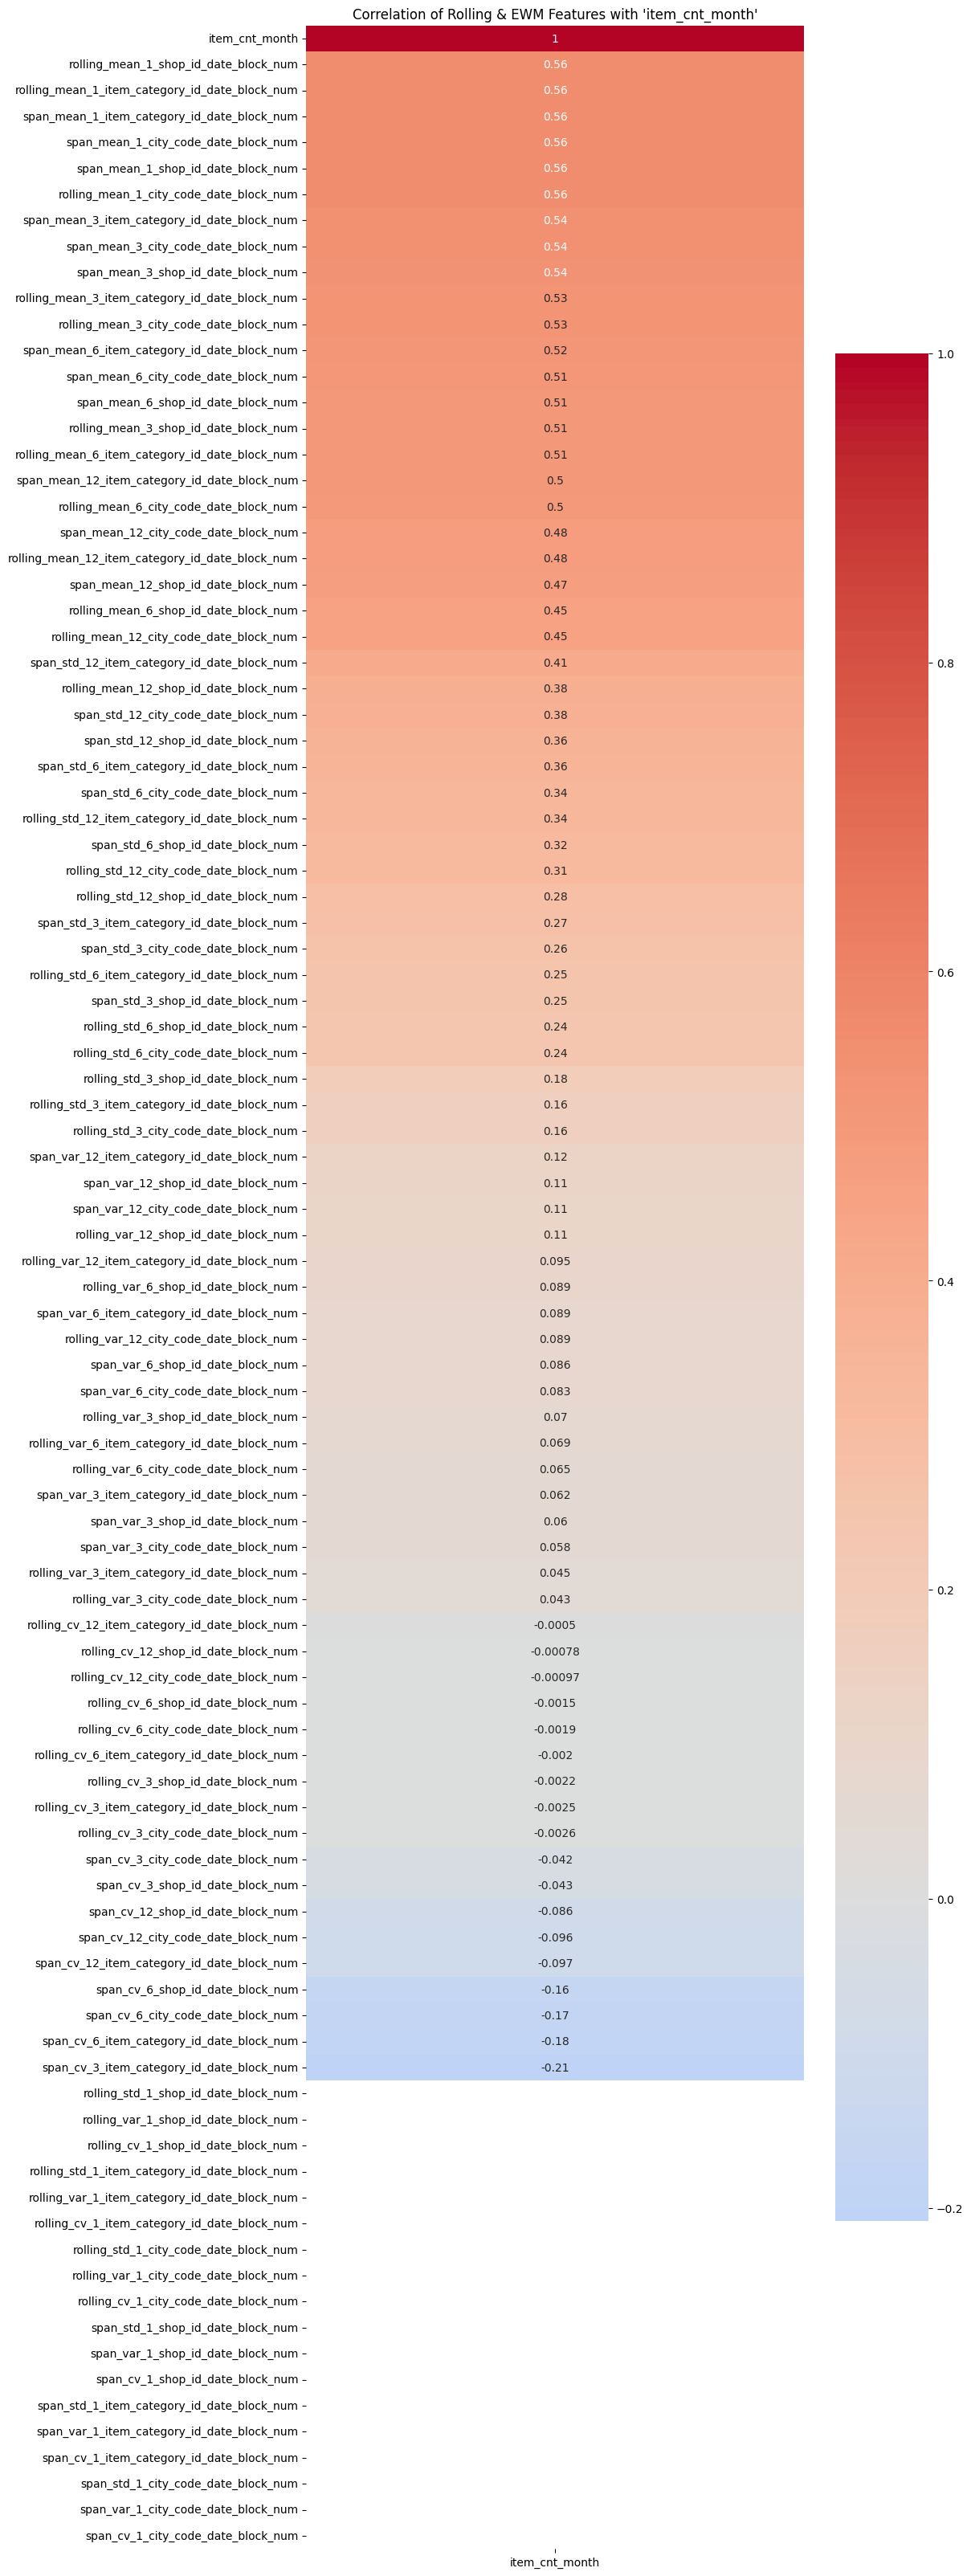

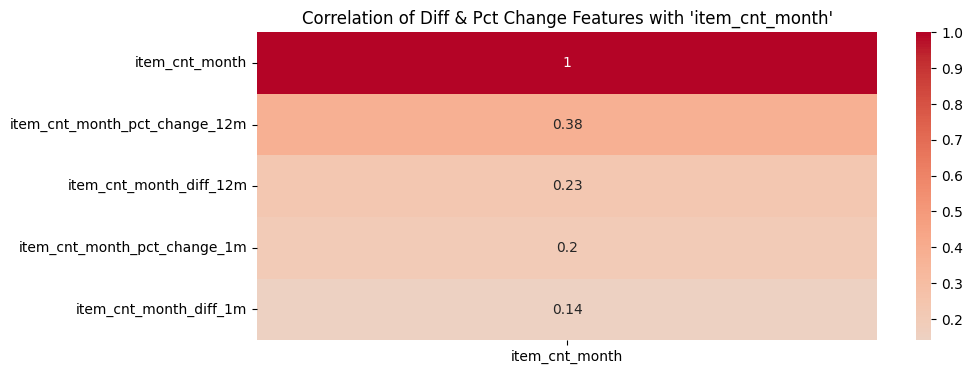

In [48]:
plot_correlation_heatmap(df, cluster_features, 'Clustering')
plot_correlation_heatmap(df, rolling_ewm_features, 'Rolling & EWM')
plot_correlation_heatmap(df, diff_pct_features, 'Diff & Pct Change')